# Preprocessing

### Load all climate data (Precip & Soil Moisture) station F102 - F108

In [8]:
%run -i function.py


In [2]:

df_station = pd.read_excel(os.getcwd()+"/Inputs/Physiography Data.xlsx",
                           engine="openpyxl", sheet_name=None, skiprows=1,)

# Print the name of each sheets


5 Stations with different soil profiles and slope.


## Load all the precipitation in the stations

In [3]:
station_name = list(df_station.keys())[:5]
station_name


['F102', 'F106', 'F107', 'F108', 'F110']

## Precipitation of all the stations


In [4]:
precipitation = df_station['F102'].iloc[:, :2].set_index('Date')

for i in station_name:
    precipitation = precipitation.merge(df_station[i].iloc[:, :2].set_index(
        'Date').rename(columns={'mm': i}), left_index=True, right_index=True)
precipitation = precipitation.drop(columns='mm')

precipitation = precipitation.replace([-996,-999], np.nan)
precipitation.describe()


,F102,F106,F107,F108,F110
count,5616.000000,5648.000000,3981.000000,5661.000000,5642.000000
mean,2.125741,2.066737,2.039206,2.019604,2.144523
std,7.847348,7.646972,7.632055,7.489740,8.103167
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,142.750000,171.450000,170.940000,160.270000,171.450000


In [5]:
# Load the excel
data = pd.read_excel(os.getcwd()+"/Inputs/Physiography Data.xlsx",
                     engine="openpyxl", sheet_name=None, )
data.keys()


dict_keys(['F102', 'F106', 'F107', 'F108', 'F110', 'MESONET HINT_TEMP', 'Discharge', 'Soils_Slopes'])

<AxesSubplot:ylabel='Date'>

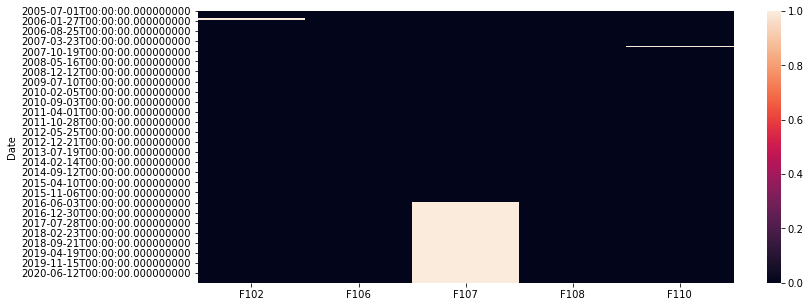

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(precipitation.isna())


,Micronet Stations,Slope %,Texture,No. Layers,Max Depth (mm)
0,f102,5.9,LFS-FSL-SL-L,4,1829
1,f106,5.5,FSL-SICL,2,1727
2,f107,0.5,FSL-SICL,2,1727
3,f108,3.7,FSL-SICL,2,1727
4,f110,2.8,FSL-SICL,2,1727


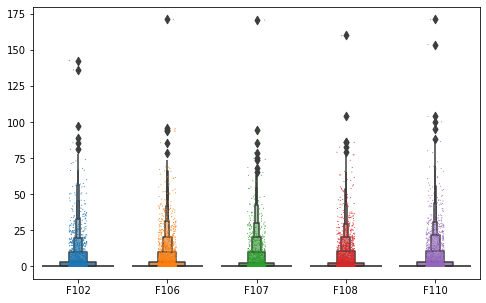

In [52]:
fig,ax = plt.subplots(figsize=(8,5))
sns.stripplot(data=precipitation, size= 1)
sns.boxenplot(data=precipitation)
data['Soils_Slopes']


In [81]:
precipitation.plot()

SyntaxError: invalid syntax (<ipython-input-81-9059badd4a73>, line 1)

In [11]:
precipitation.describe()


,F102,F106,F107,F108,F110
count,5616.000000,5648.000000,3981.000000,5661.000000,5642.000000
mean,2.125741,2.066737,2.039206,2.019604,2.144523
std,7.847348,7.646972,7.632055,7.489740,8.103167
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,142.750000,171.450000,170.940000,160.270000,171.450000


Stations with the least missing precipitaion values are preferred for analysis listed below in descending order
- F106
- F110
- F102
- F107

Check the correlation between the precipitation at the different station 

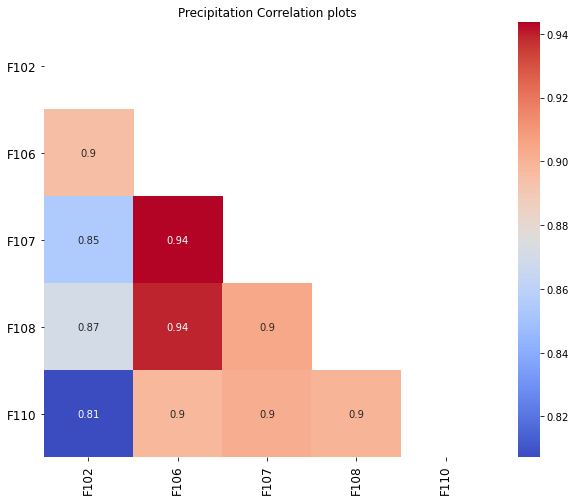

In [45]:
corr_plot(precipitation, 'Precipitation Correlation plots')


We choose the station with the most complete precipitation "F108".
<mark>F108</mark> has a high correlation with <mark>F106</mark> station that happens to be the next complete.
They both have the same soil property but different slopes


In [46]:
data["Soils_Slopes"]


,Micronet Stations,Slope %,Texture,No. Layers,Max Depth (mm)
0,f102,5.9,LFS-FSL-SL-L,4,1829
1,f106,5.5,FSL-SICL,2,1727
2,f107,0.5,FSL-SICL,2,1727
3,f108,3.7,FSL-SICL,2,1727
4,f110,2.8,FSL-SICL,2,1727


## Load the Temperature data

We have a single temperature data for all the stations located in sheetnamae <mark> MESONET HINT_TEMP</mark>

In [47]:
# Obtain the Mesonet Temperature Min and Max temperature
Temperature = data["MESONET HINT_TEMP"].set_index('Date')
#Temperature.rename(columns={"TMAX (C)" : "TMAX ", 'TMIN (C)': "TMAX"})

# Merge the temperature and precipitation for the F108 station
df_F108 = Temperature.merge(precipitation['F108'], how='inner', on='Date')
df_F108 = df_F108.rename(columns={'F108': "PRCP (mm)"})


In [48]:
status(df_F108)


+-----------+--------------+---------------+------------+
| Features  | Observations | No of missing | % Missing  |
+-----------+--------------+---------------+------------+
| TMAX (C)  |     5663     |       0       |    0.0%    |
| TMIN (C)  |     5663     |       0       |    0.0%    |
| PRCP (mm) |     5663     |       2       |    0.0%    |
+-----------+--------------+---------------+------------+


In [49]:
# replace all odd values due to instrument reading and linear interpolate
df_F108 = df_F108.replace(-571.105400, np.nan)
df_F108 = df_F108.interpolate(method='linear', limit_direction='both')
status(df_F108)


+-----------+--------------+---------------+------------+
| Features  | Observations | No of missing | % Missing  |
+-----------+--------------+---------------+------------+
| TMAX (C)  |     5663     |       0       |    0.0%    |
| TMIN (C)  |     5663     |       0       |    0.0%    |
| PRCP (mm) |     5663     |       0       |    0.0%    |
+-----------+--------------+---------------+------------+


## Merge the soil properties, temperature and precipitation 

In [50]:
df_F108 = df_F108.merge(df_station['F108'].drop(columns='mm'),
                        how='inner', on='Date')

# set the date as the index of the dataframe
df_F108 = df_F108.set_index('Date')

# Rename the soil columns
df_F108 = df_F108.rename(columns={"5 cm": "SM 5 (cm)",
                                  "25 cm": "SM 25 (cm)",
                                  "45 cm": "SM 45 (cm)"})


### Deal with the missing values.

In [51]:
# replace all the -998  adn -996 with np.nan
df_F108 = df_F108.replace([-998, -996], np.nan)

status(df_F108)


+------------+--------------+---------------+------------+
|  Features  | Observations | No of missing | % Missing  |
+------------+--------------+---------------+------------+
|  TMAX (C)  |     5663     |       0       |    0.0%    |
|  TMIN (C)  |     5663     |       0       |    0.0%    |
| PRCP (mm)  |     5663     |       0       |    0.0%    |
| SM 5 (cm)  |     5663     |      88       |    1.6%    |
| SM 25 (cm) |     5663     |      88       |    1.6%    |
| SM 45 (cm) |     5663     |      88       |    1.6%    |
+------------+--------------+---------------+------------+


<AxesSubplot:ylabel='Date'>

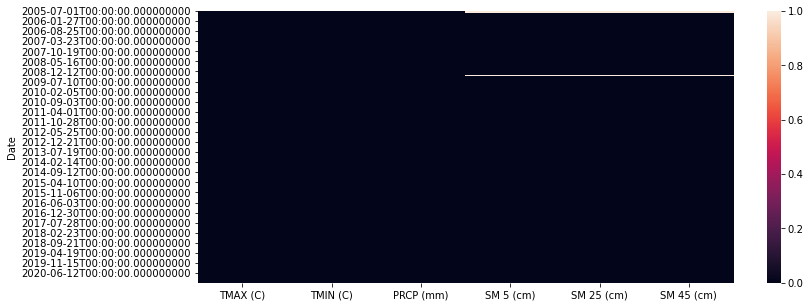

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df_F108.isna())


In [53]:
display_side_by_side([sequence_of_missing_values(df_F108, 'SM 5 (cm)'),
                     sequence_of_missing_values(df_F108, 'SM 25 (cm)'), sequence_of_missing_values(df_F108, 'SM 45 (cm)')],
                     ['5cm', '25cm', '45cm']
                     )


,Start_Date,End_Date,Frequency
0,'2005-07-01','2005-08-25',56
1,'2009-03-01','2009-03-30',30
2,'2013-08-19','2013-08-20',2
,Start_Date,End_Date,Frequency
0,'2005-07-01','2005-08-25',56
1,'2009-03-01','2009-03-30',30
2,'2013-08-19','2013-08-20',2
,Start_Date,End_Date,Frequency
0,'2005-07-01','2005-08-25',56
1,'2009-03-01','2009-03-30',30


Drop the first 56 rows till 2005-08-26 and linear interpolate the dataframe

In [54]:
df_F108 = df_F108.loc['2005-08-26':].interpolate(
    method='linear', limit_direction='both')
status(df_F108)


+------------+--------------+---------------+------------+
|  Features  | Observations | No of missing | % Missing  |
+------------+--------------+---------------+------------+
|  TMAX (C)  |     5607     |       0       |    0.0%    |
|  TMIN (C)  |     5607     |       0       |    0.0%    |
| PRCP (mm)  |     5607     |       0       |    0.0%    |
| SM 5 (cm)  |     5607     |       0       |    0.0%    |
| SM 25 (cm) |     5607     |       0       |    0.0%    |
| SM 45 (cm) |     5607     |       0       |    0.0%    |
+------------+--------------+---------------+------------+


# Feature Engineering

- create median and mean precipitations weekly and yearly frequency. 
- check the correlation between features on both time format.
- load the yearly yeild
- Split the data into train and test
- Create the pipeline no tuning yet
-- XGBoost
-- Catboost
-- Random Forest
-- ExtraTree

## Correlation plots

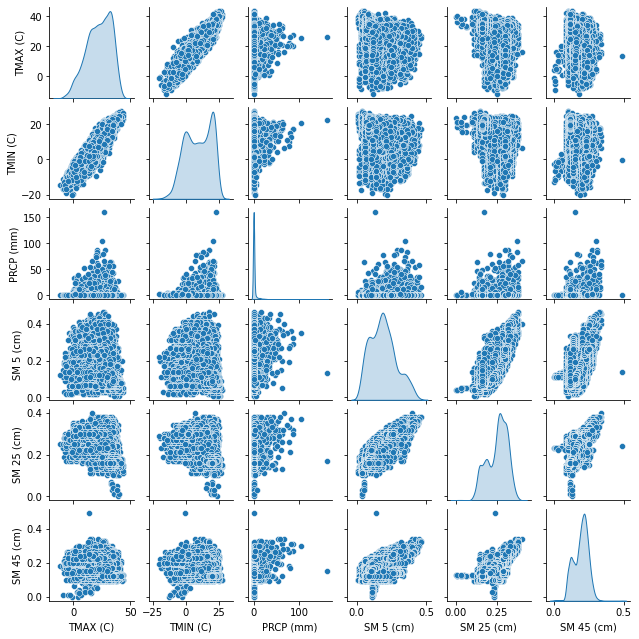

In [55]:
sns.pairplot(df_F108, diag_kind='kde', height=1.5)


### resample to weekly values and check correlation


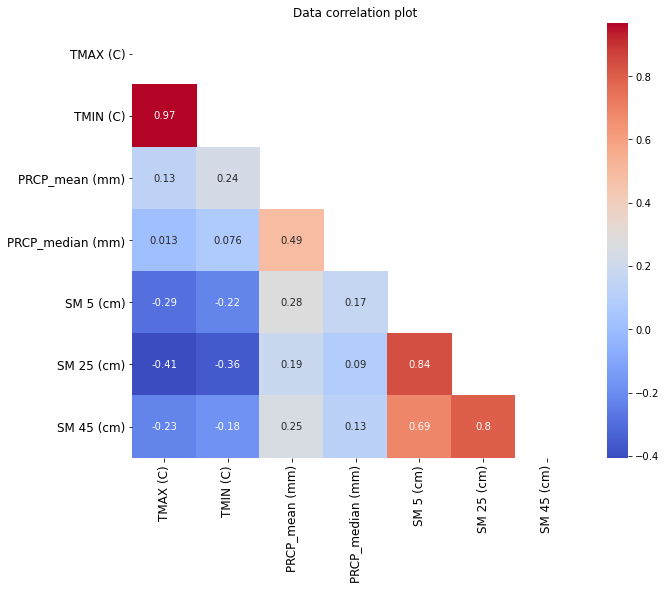

In [56]:
# Resample the temperature
resampled = df_F108[['TMAX (C)', "TMIN (C)"]].resample('W').mean()
# Resample the Precipitation mean and median
resampled["PRCP_mean (mm)"] = df_F108["PRCP (mm)"].resample('W').mean()
resampled["PRCP_median (mm)"] = df_F108["PRCP (mm)"].resample('W').median()
# Resample the SM
resampled_SM = df_F108.iloc[:, 3:].resample('W').mean()
# The transformed precipitation mean and median

df_F108_resampled = resampled.merge(resampled_SM, on='Date', how="inner")


corr_plot(df_F108_resampled, 'Data correlation plot')


The pearson correlation shows that the resampled weekly mean PRCP (mm) has a higher correlation with other features than the median

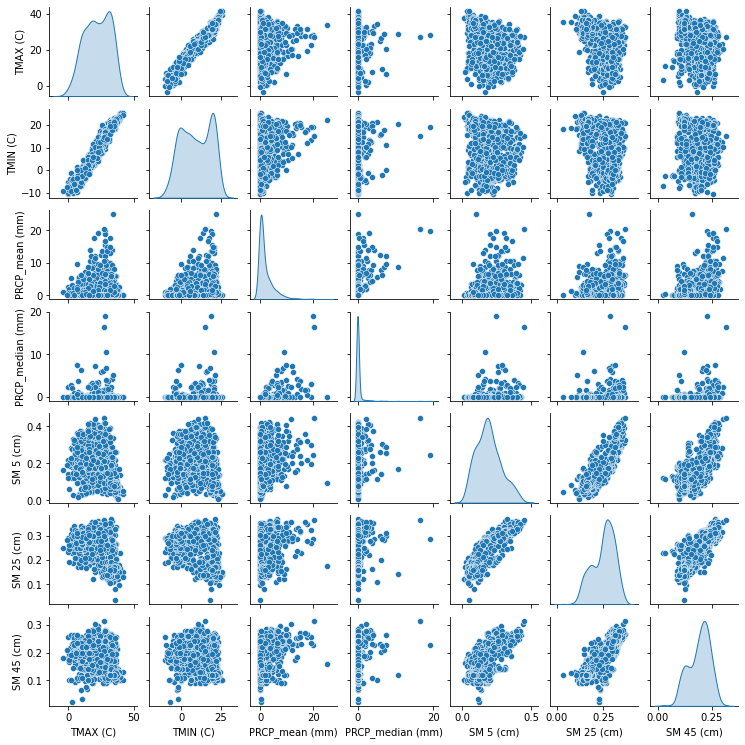

In [57]:
sns.pairplot(df_F108_resampled, diag_kind='kde', height=1.5)


# df_AI

In [58]:
df_AI = df_F108_resampled.drop(columns=["PRCP_median (mm)"])

df_AI = df_AI.rename(columns={"PRCP_mean (mm)": "$P [mm]$",
                              "TMAX (C)": "$T_{max}$ [$^oC$]",
                              "TMIN (C)": '$T_{min}$ [$^oC$]',
                              "SM 5 (cm)": "$SM_{5} [cm]$",
                              "SM 25 (cm)": "$SM_{25} [cm]$",
                              "SM 45 (cm)": "$SM_{45} [cm]$"})

#corr_plot(df_AI, 'DF_AI correlation plot')


In [59]:
df_AI['Month'] = df_AI.index.month

# Precipitation Lags
df_AI['$P^{lag1} [mm]$'] = df_AI["$P [mm]$"].shift(1)
df_AI['$P^{lag2} [mm]$'] = df_AI["$P [mm]$"].shift(2)


# Temperature Lags
#df_AI['$T_{max}^{lag1}$ [$^oC$]'] = df_AI['$T_{max}$ [$^oC$]'].shift(1)
#df_AI['$T_{max}^{lag2}$ [$^oC$]'] = df_AI['$T_{max}$ [$^oC$]'].shift(2)

#df_AI['$T_{min}^{lag1}$ [$^oC$]'] = df_AI['$T_{min}$ [$^oC$]'].shift(1)
#df_AI['$T_{min}^{lag2}$ [$^oC$]'] = df_AI['$T_{min}$ [$^oC$]'].shift(2)

# Soil Moisture Lags

#df_AI["$SM_{5}^{lag1}[cm]$"] = df_AI["$SM_{5} [cm]$"].shift(1)
#df_AI["$SM_{5}^{lag2}[cm]$"] = df_AI["$SM_{5} [cm]$"].shift(2)


In [60]:
prcp = df_AI.loc[:, df_AI.columns.str.startswith('$P')]
temp = df_AI.loc[:, df_AI.columns.str.startswith('$T')]
sm = df_AI.loc[:, df_AI.columns.str.startswith('$S')]


df_AI = temp.merge(prcp, on='Date').merge(sm, on="Date").dropna()


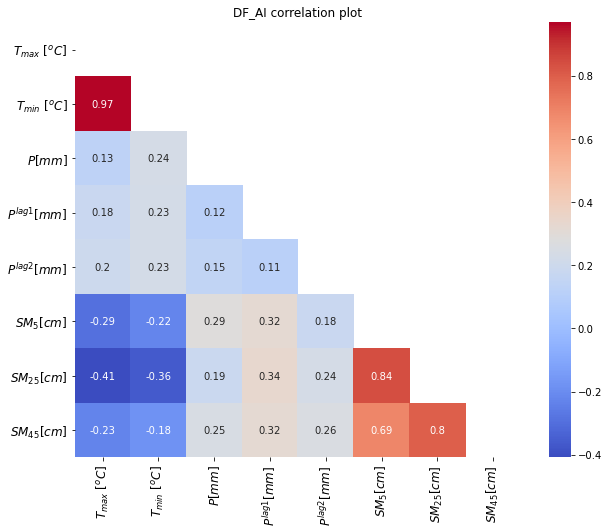

In [61]:
corr_plot(df_AI, 'DF_AI correlation plot')


# Load the yearly crop yeild data

In [62]:
current_directory = os.getcwd()
file_location = r'/Inputs/Lake Creek Crop Yield Data.xlsx'

crop_yield = pd.read_excel(
    current_directory+file_location, engine="openpyxl", sheet_name=None)
crop_yield.keys()


dict_keys(['Lake Wheat Acres Planted', 'Caddo County Wheat Yield'])

In [63]:
crop_yield = crop_yield['Caddo County Wheat Yield'].set_index("Year")
crop_yield = crop_yield.dropna()
crop_yield = crop_yield.iloc[::-1]
crop_yield.describe()

,bu/ac *,t/ha,Caddo Estimated Acres,Caddo Estimated Hectare
count,16.000000,16.000000,16.000000,16.000000
mean,30.775000,2.071157,10340.400000,4186.396761
std,7.629111,0.513439,2563.381267,1037.806181
min,16.000000,1.076800,5376.000000,2176.518219
25%,24.700000,1.662310,8299.200000,3360.000000
50%,31.600000,2.126680,10617.600000,4298.623482
75%,36.050000,2.426165,12112.800000,4903.967611
max,42.800000,2.880440,14380.800000,5822.186235


In [64]:
# Resample the temperature to yearly
AI = df_F108[['TMAX (C)', "TMIN (C)"]].resample('Y').mean()
# Resample the Precipitation mean and median yearly
AI["$P [mm]$"] = df_F108["PRCP (mm)"].resample('Y').mean()
#AI['$P^{lag1} [mm]$'] = df_F108["PRCP (mm)"].shift(1).resample('Y').mean()
#AI['$P^{lag2} [mm]$'] = df_F108["PRCP (mm)"].shift(2).resample('Y').mean()
# Resample the Soil moisture to yearly ``
AI_SM = df_F108.iloc[:, 3:].resample('Y').mean().rename_axis('Year')
# refomat the index to fit the crop yeild
AI_SM.index = AI_SM.index.strftime("%Y")
AI = AI.rename_axis('Year')
AI.index = AI.index.strftime("%Y")

AI['$P^{lag1} [mm]$'] = AI["$P [mm]$"].shift(1)
AI['$P^{lag2} [mm]$'] = AI["$P [mm]$"].shift(2)
# Merge dataframes AI , AI_SM and crop yield
AI = AI.merge(AI_SM, on= 'Year', how = 'inner')

AI['t/ha'] = crop_yield['t/ha'].values


In [65]:
AI = AI.rename(columns={"TMAX (C)": "$T_{max}$ [$^oC$]",
                              "TMIN (C)": '$T_{min}$ [$^oC$]',
                              "SM 5 (cm)": "$SM_{5} [cm]$",
                              "SM 25 (cm)": "$SM_{25} [cm]$",
                              "SM 45 (cm)": "$SM_{45} [cm]$"})


In [66]:
dfai = AI.copy()

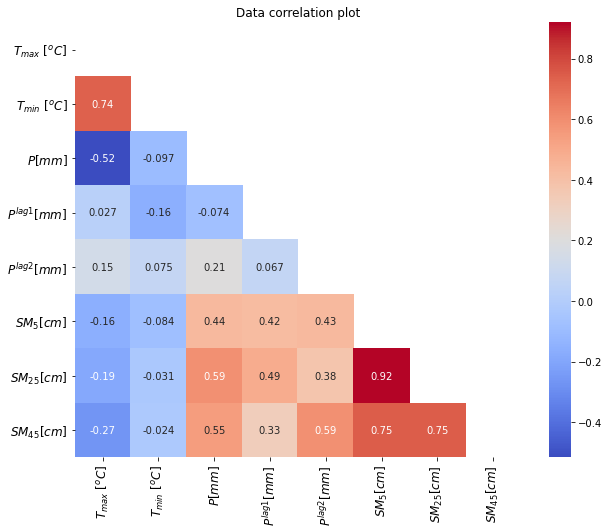

In [67]:
AI = AI.dropna()
corr_plot(AI.iloc[:,:-1], 'Data correlation plot')


## Build Model Pipeline

In [83]:
X = AI.iloc[:, :-1].values
y = AI.iloc[:, -1:].values


X_train, X_test, y_train, y_test = train_test_split( X, 
                                                    y.ravel(),
                                                     test_size=0.3)
                                                     

pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


#model = pipeline_RF.fit(X_train, y_train)


In [94]:
def results(x, y, x_t, y_t, pipelines):
    table = PrettyTable()

    # Fit the pipelines
    [pipe.fit(x, y) for pipe in pipelines]

    pipe_dict = {0: 'RandomForest', 1: 'XGBoost', 2: 'ExtraTree'}

    results = [[pipe_dict[i],
                np.round(r2_score(y, model.predict(x)), decimals=2),
                np.round(np.sqrt(mean_squared_error(y, model.predict(x))), decimals=2)]
               for i, model in enumerate(pipelines)]
    table.title = 'Training set score'
    table.field_names = ['Algorithm', 'R-square', 'RMSE']
    table.add_rows(results)
    print(table)

    table = PrettyTable()

    #################################################################################################
    # Make predictions on testing data and test model accuracy
    #################################################################################################
    results2 = []
    model_results = {}
    i = 0
    count = 0
    for model in pipelines:
        history = np.empty(len(x_t))
        test_X = x_t[0].reshape(1, -1)
        history[0] = model.predict(test_X)

        for i in range(len(x_t)):

            #x_t[i+1][-2] = history[i]
            #x_t[i+1][-1] = x_t[i][-2]

            test_X = x_t[i+1].reshape(1, -1)
            history[i+1] = model.predict(test_X)
            i = i+1
            if i == (len(x_t)-1):
                break
        results2.append([model.steps[0][0],
                         np.round(
                             r2_score(np.sort(y_t), np.sort(history)), decimals=2),
                         np.round(np.sqrt(mean_squared_error(np.sort(y_t), np.sort(history))), decimals=2)])
        model_results[model.steps[0][0]] = history
        count = count + 1

    table.title = 'Test set Score'
    table.field_names = ['Algorithm', 'R-square', 'RMSE']

    table.add_rows(results2)

    print(table)

    return model_results


In [95]:
holdem = results(X_train, y_train, X_test, y_test, pipeliner)


+--------------------------------+
|       Training set score       |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.81   | 0.23 |
|   XGBoost    |   1.0    | 0.0  |
|  ExtraTree   |   1.0    | 0.0  |
+--------------+----------+------+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.8    | 0.2  |
|   XGBoost    |   0.71   | 0.25 |
|  ExtraTree   |   0.7    | 0.25 |
+--------------+----------+------+


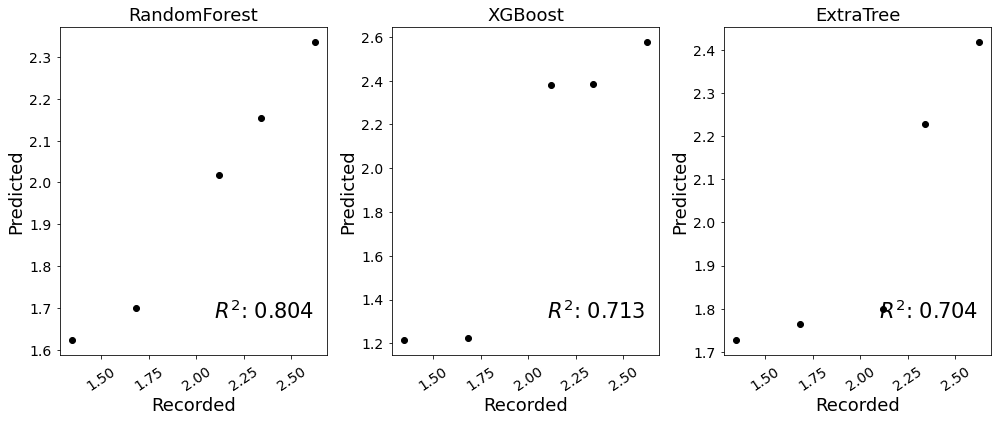

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
# ###################################################################################################

for count, model_name in enumerate(holdem):

    ax[count].scatter(np.sort(y_test), np.sort(holdem[model_name]),
                      marker='o', color='black')

    RSQ = np.round((r2_score(np.sort(y_test), np.sort(holdem[model_name]))), 3)

    ax[count].text(0.95, 0.1, ("$R^2$: %0.03f" % RSQ),
                   verticalalignment='bottom', horizontalalignment='right',
                   transform=ax[count].transAxes,
                   color='black', fontsize=21)

    ax[count].set_xlabel('Recorded', fontsize=18)
    ax[count].tick_params(axis="x", labelsize=14, rotation=34)
    ax[count].xaxis.set_tick_params(pad=5)
    ax[count].set_ylabel('Predicted', fontsize=18)
    ax[count].tick_params(axis="y", labelsize=14)
    ax[count].yaxis.set_tick_params(pad=5)
    ax[count].set_title(model_name, size=18)

    plt.tight_layout(pad=1.2)

plt.show()


 Randomforest gives the best results for the test result although performs the least on training 
 while the RMSE is equal for both the XGBoost and the Extratree

## Shapley Analysis

In [72]:
path_to_save = current_directory+r'/F108'
os.mkdir(path_to_save)

FileExistsError: [Errno 17] File exists: '/home/c0d3b23ak32/Desktop/XAI/Food_Production/F108'

In [90]:
Features = list(AI.iloc[:, :-1].columns)
Features 

['$T_{max}$ [$^oC$]',
 '$T_{min}$ [$^oC$]',
 '$P [mm]$',
 '$P^{lag1} [mm]$',
 '$P^{lag2} [mm]$',
 '$SM_{5} [cm]$',
 '$SM_{25} [cm]$',
 '$SM_{45} [cm]$']

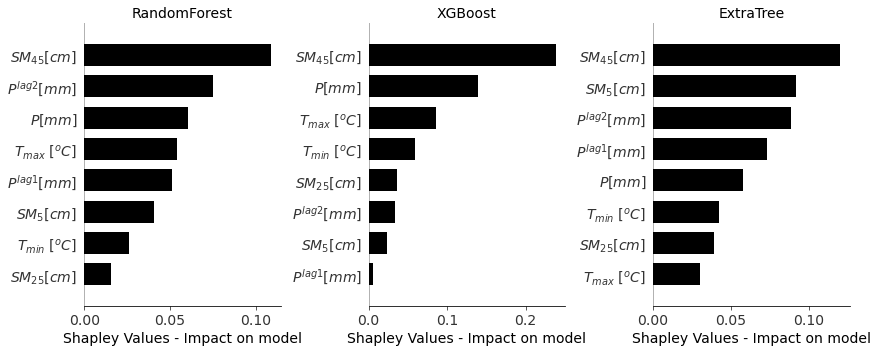

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(32, 5))
gs = gridspec.GridSpec(1, 3)
keep = {}
for count, model in enumerate(pipeliner):
    Modeled = model[0].fit(X, y.ravel())
    explainer = shap.TreeExplainer(Modeled)
    shap_values = explainer.shap_values(X)
    ax = fig.add_subplot(gs[0, count])
    shap.summary_plot(shap_values, X, Features, show=False,
                      plot_type="bar", color="black", plot_size=(12, 5))
    plt.xlabel('Shapley Values - Impact on model', fontsize=14)
    plt.tick_params(labelsize=14)
    # plt.ylabel(labelsize=16)
    plt.tight_layout(pad=1.2)
    plt.title(model.steps[0][0], fontsize=14)
    keep[model.steps[0][0]] = shap_values
    fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.savefig(path_to_save+r'/Histogram-importance.jpg',
            format='jpeg', dpi=300, bbox_inches='tight')
plt.show()


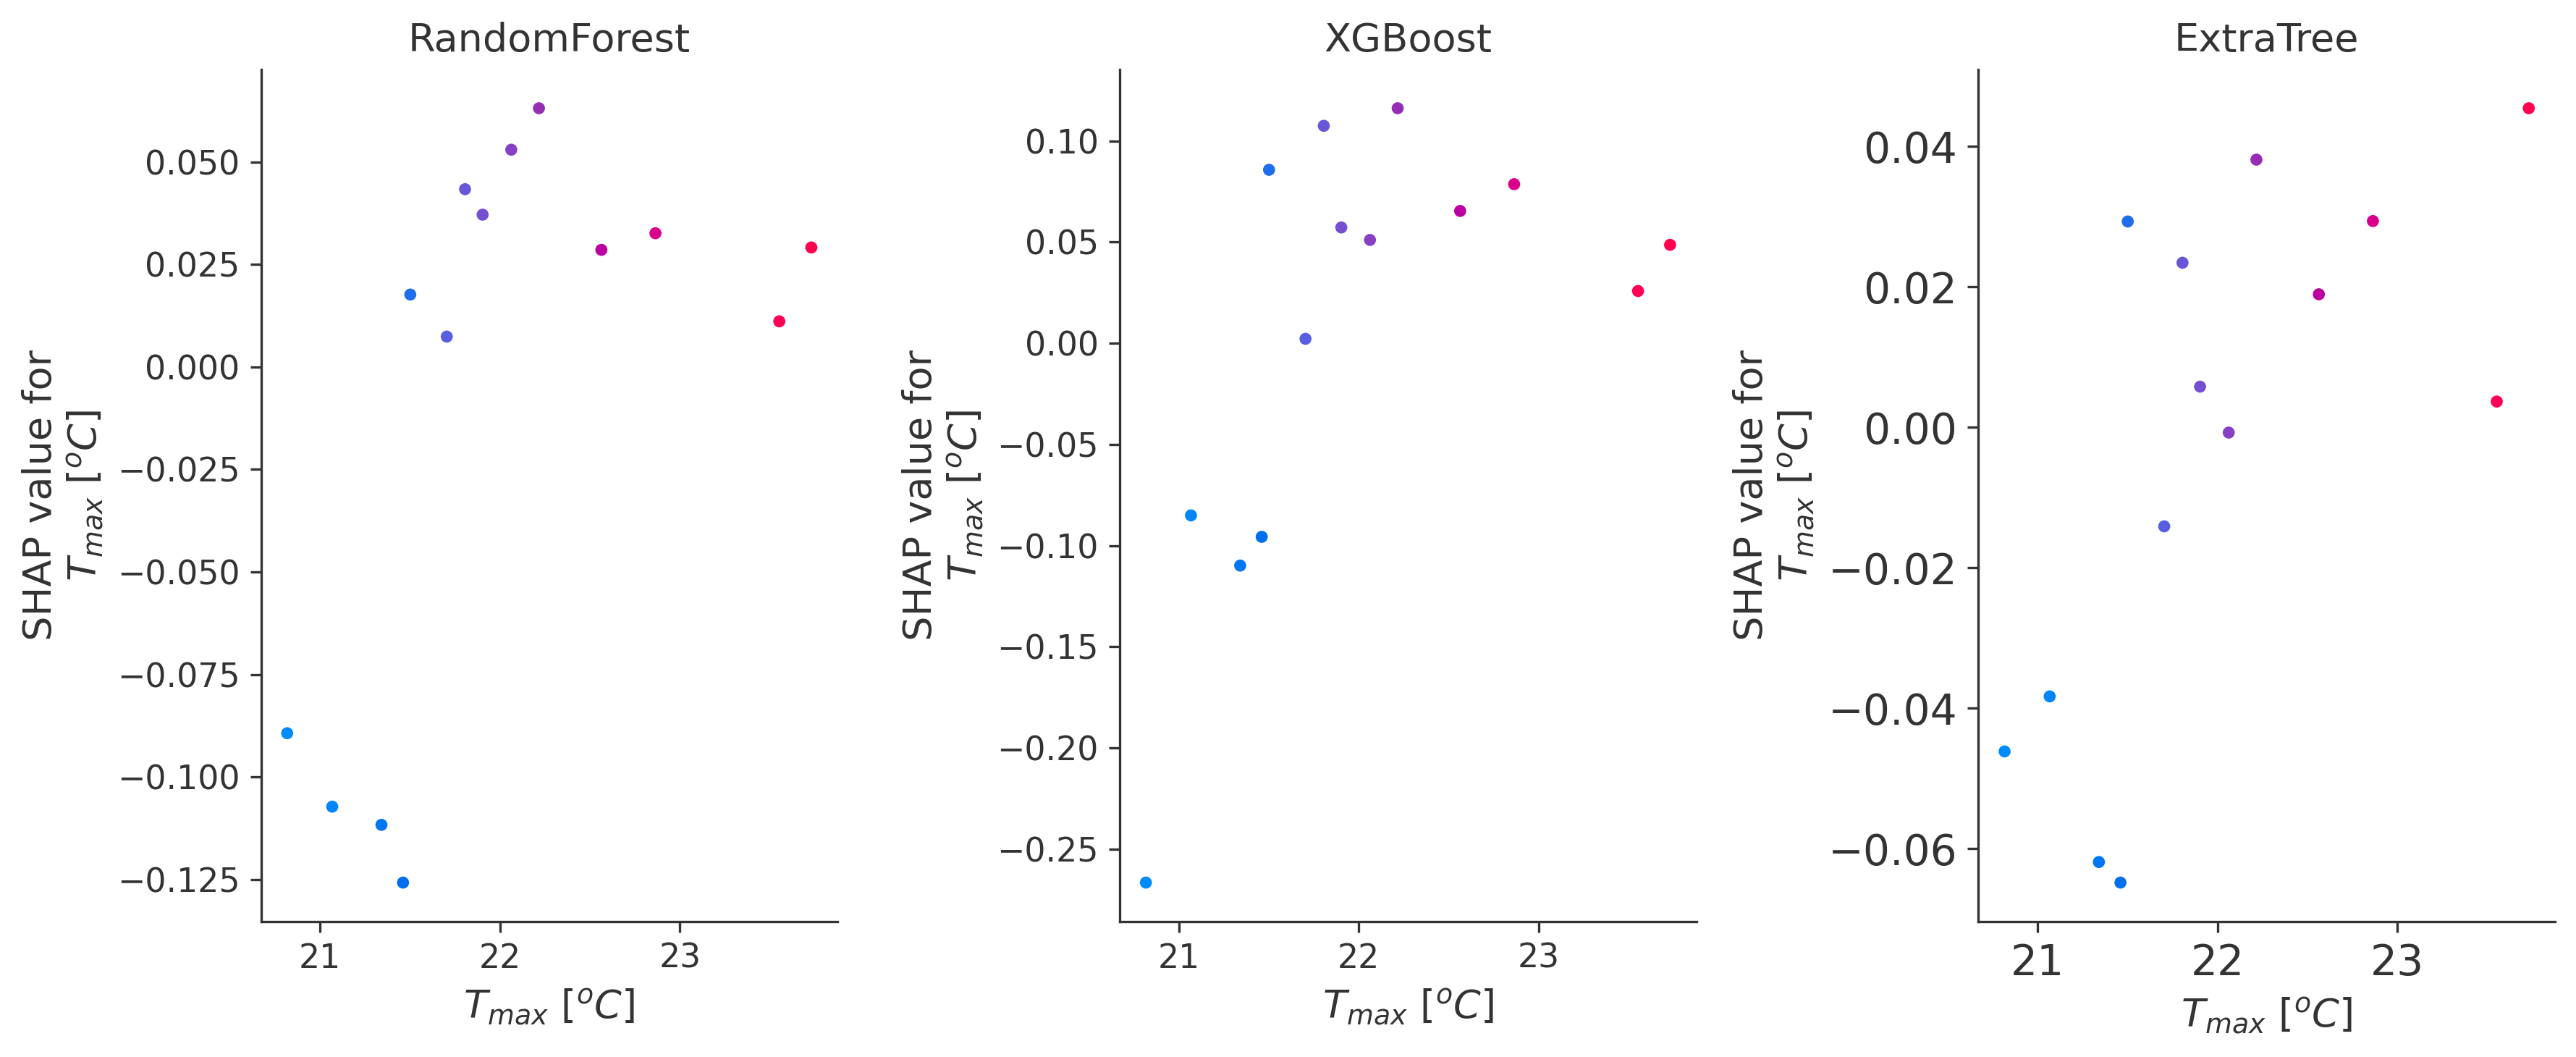

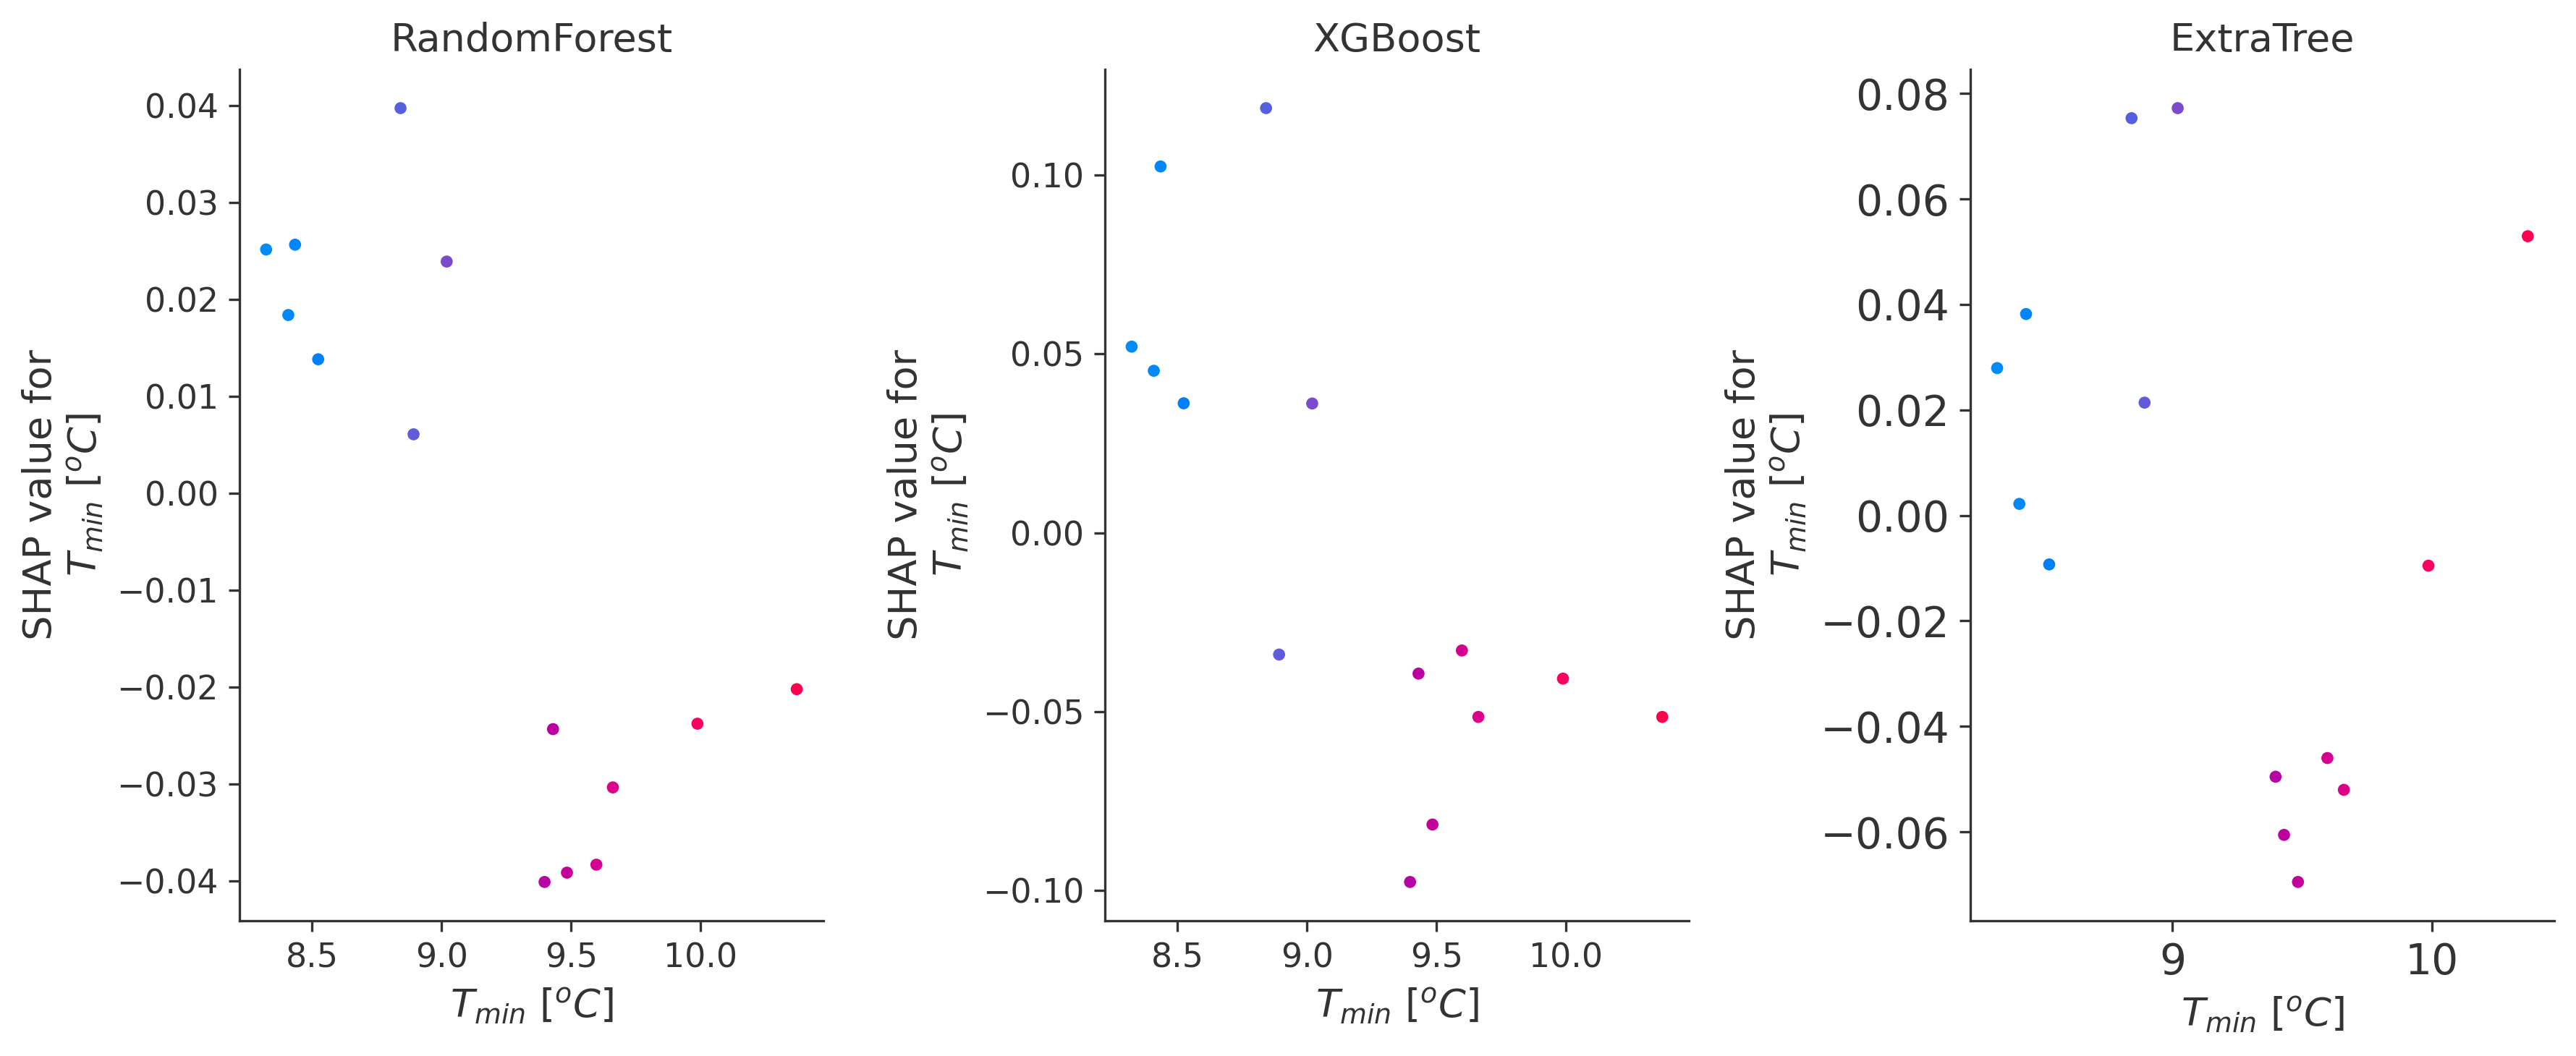

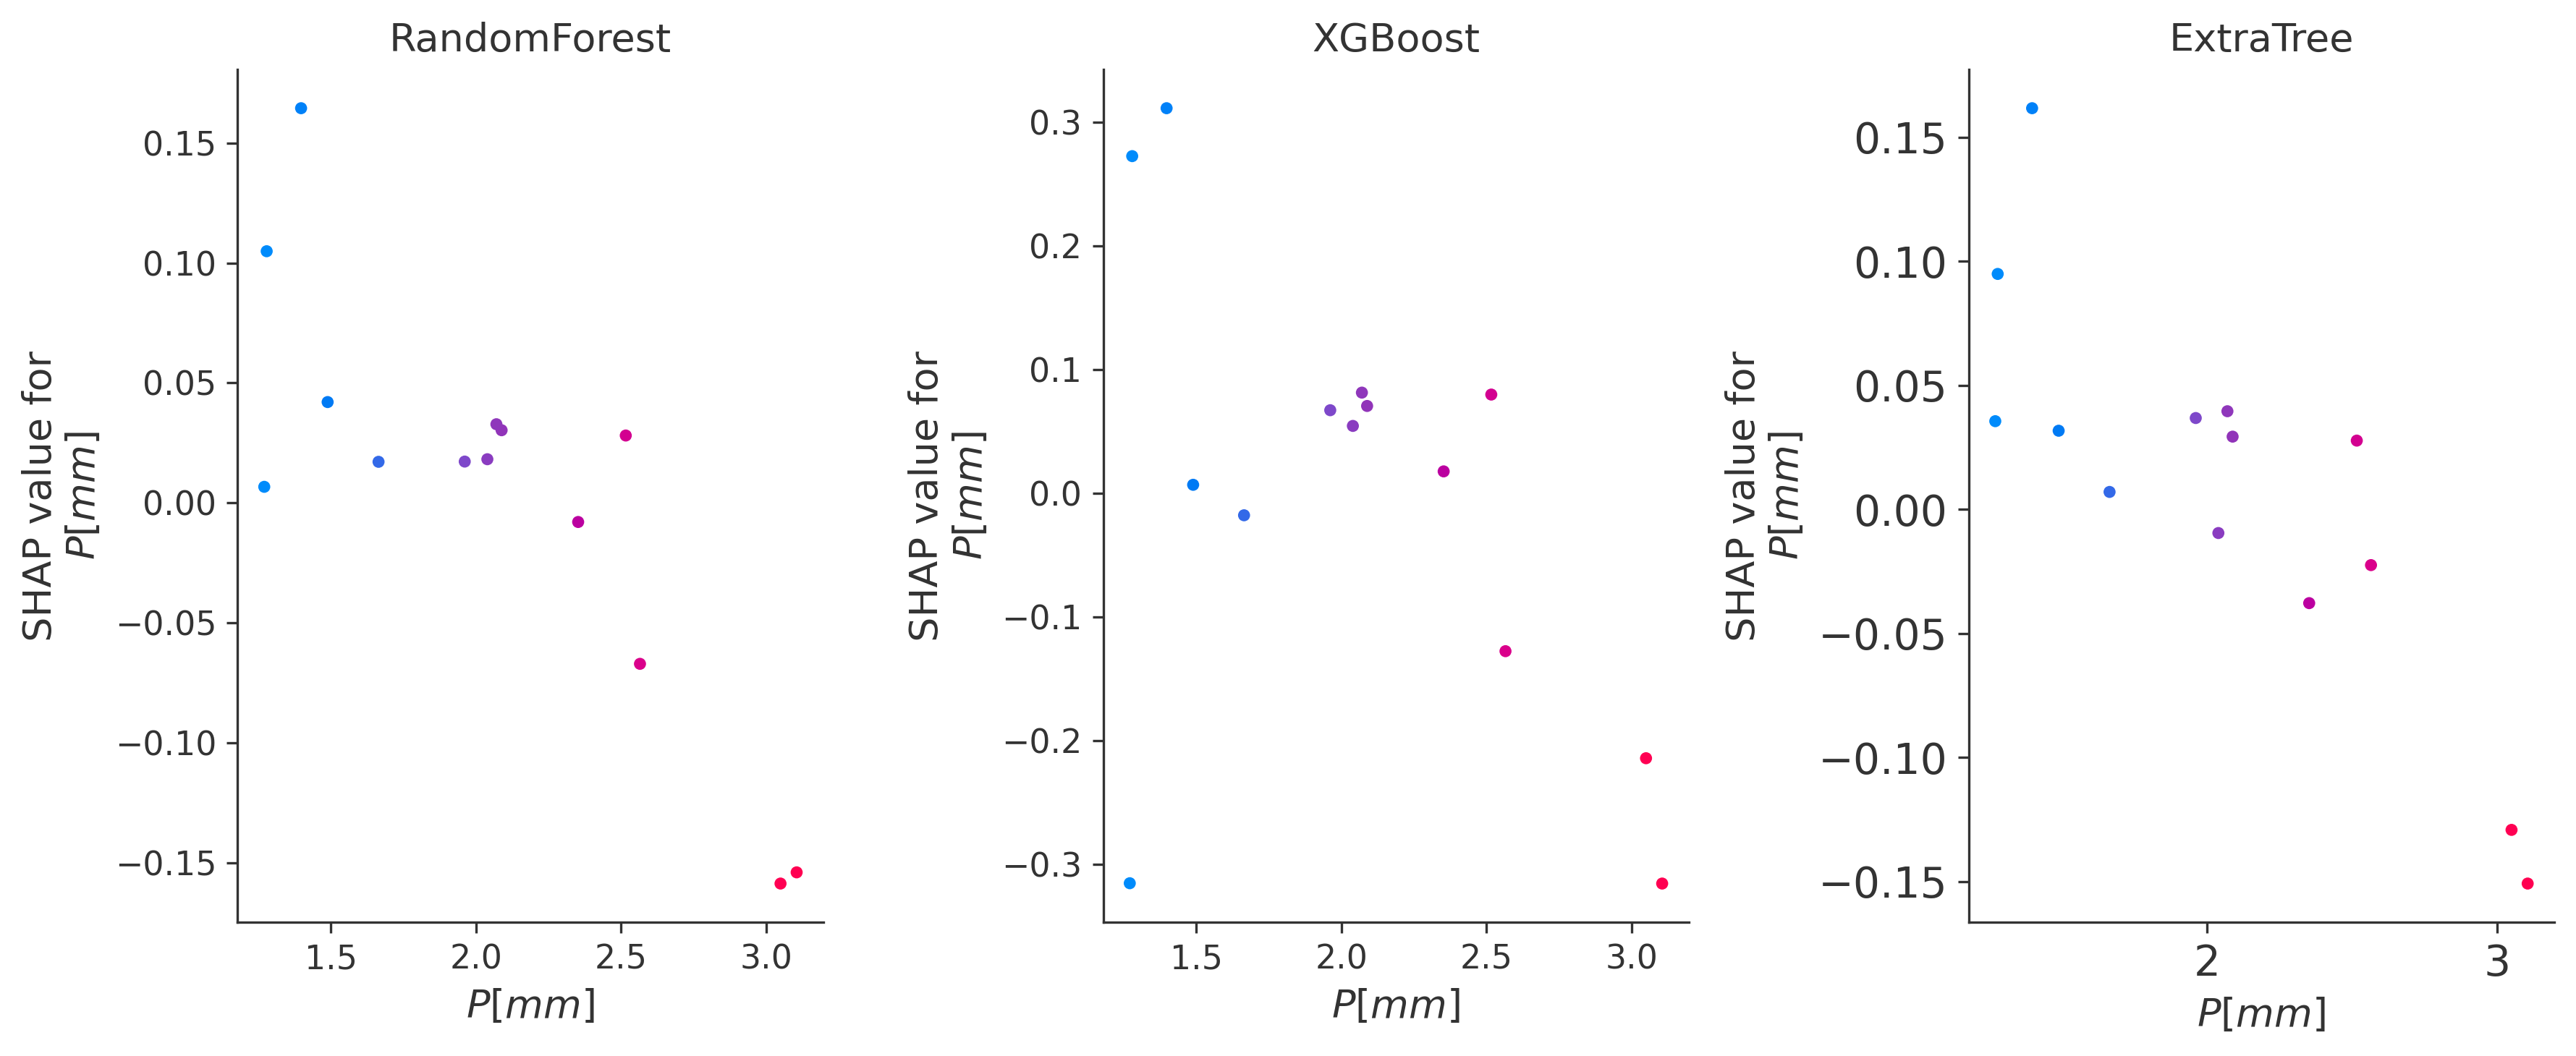

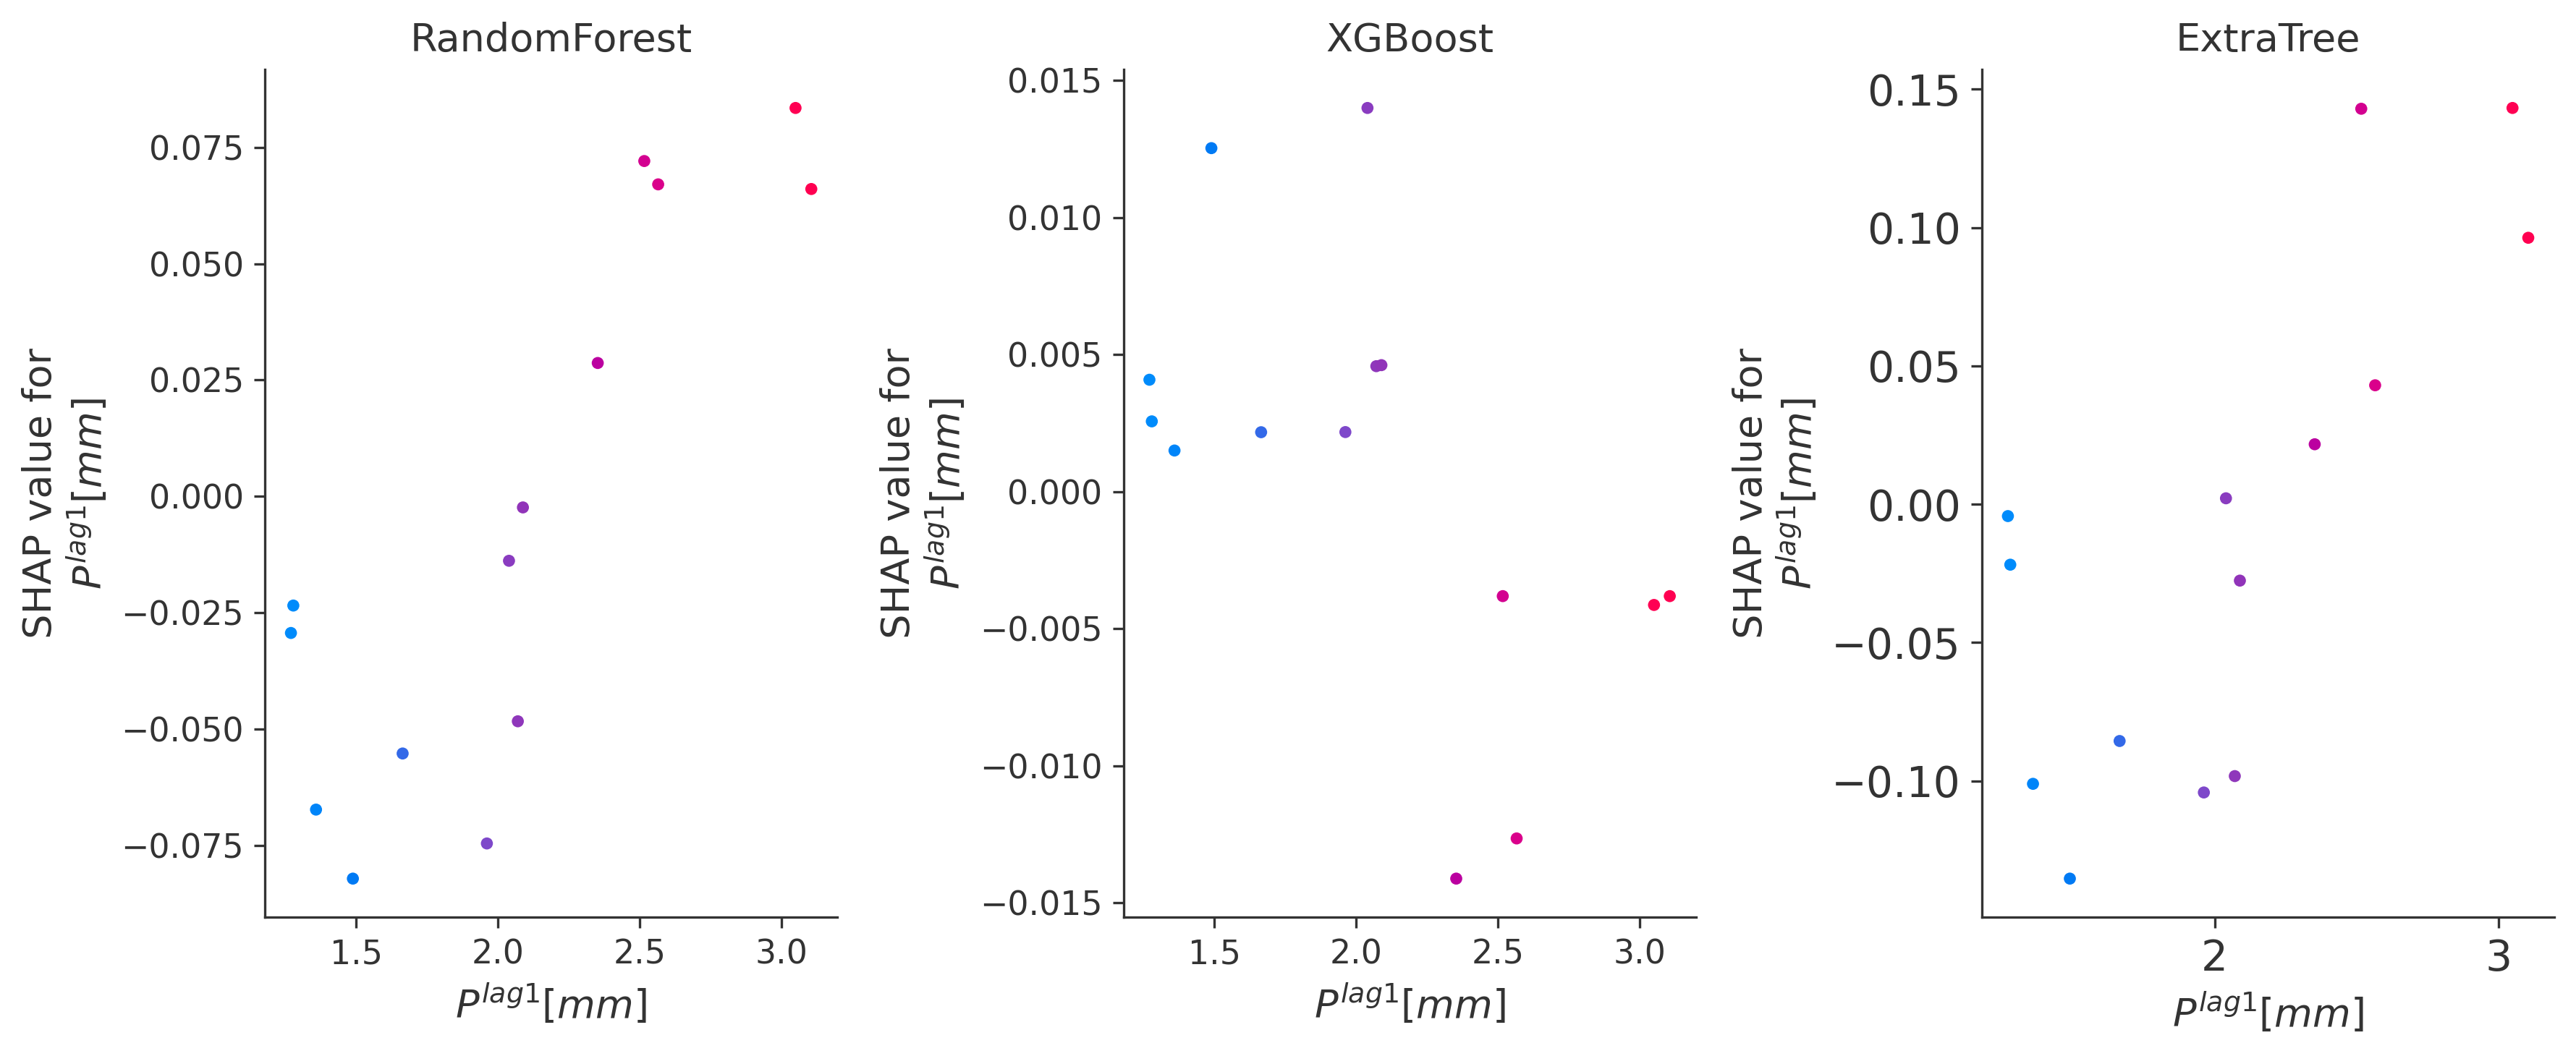

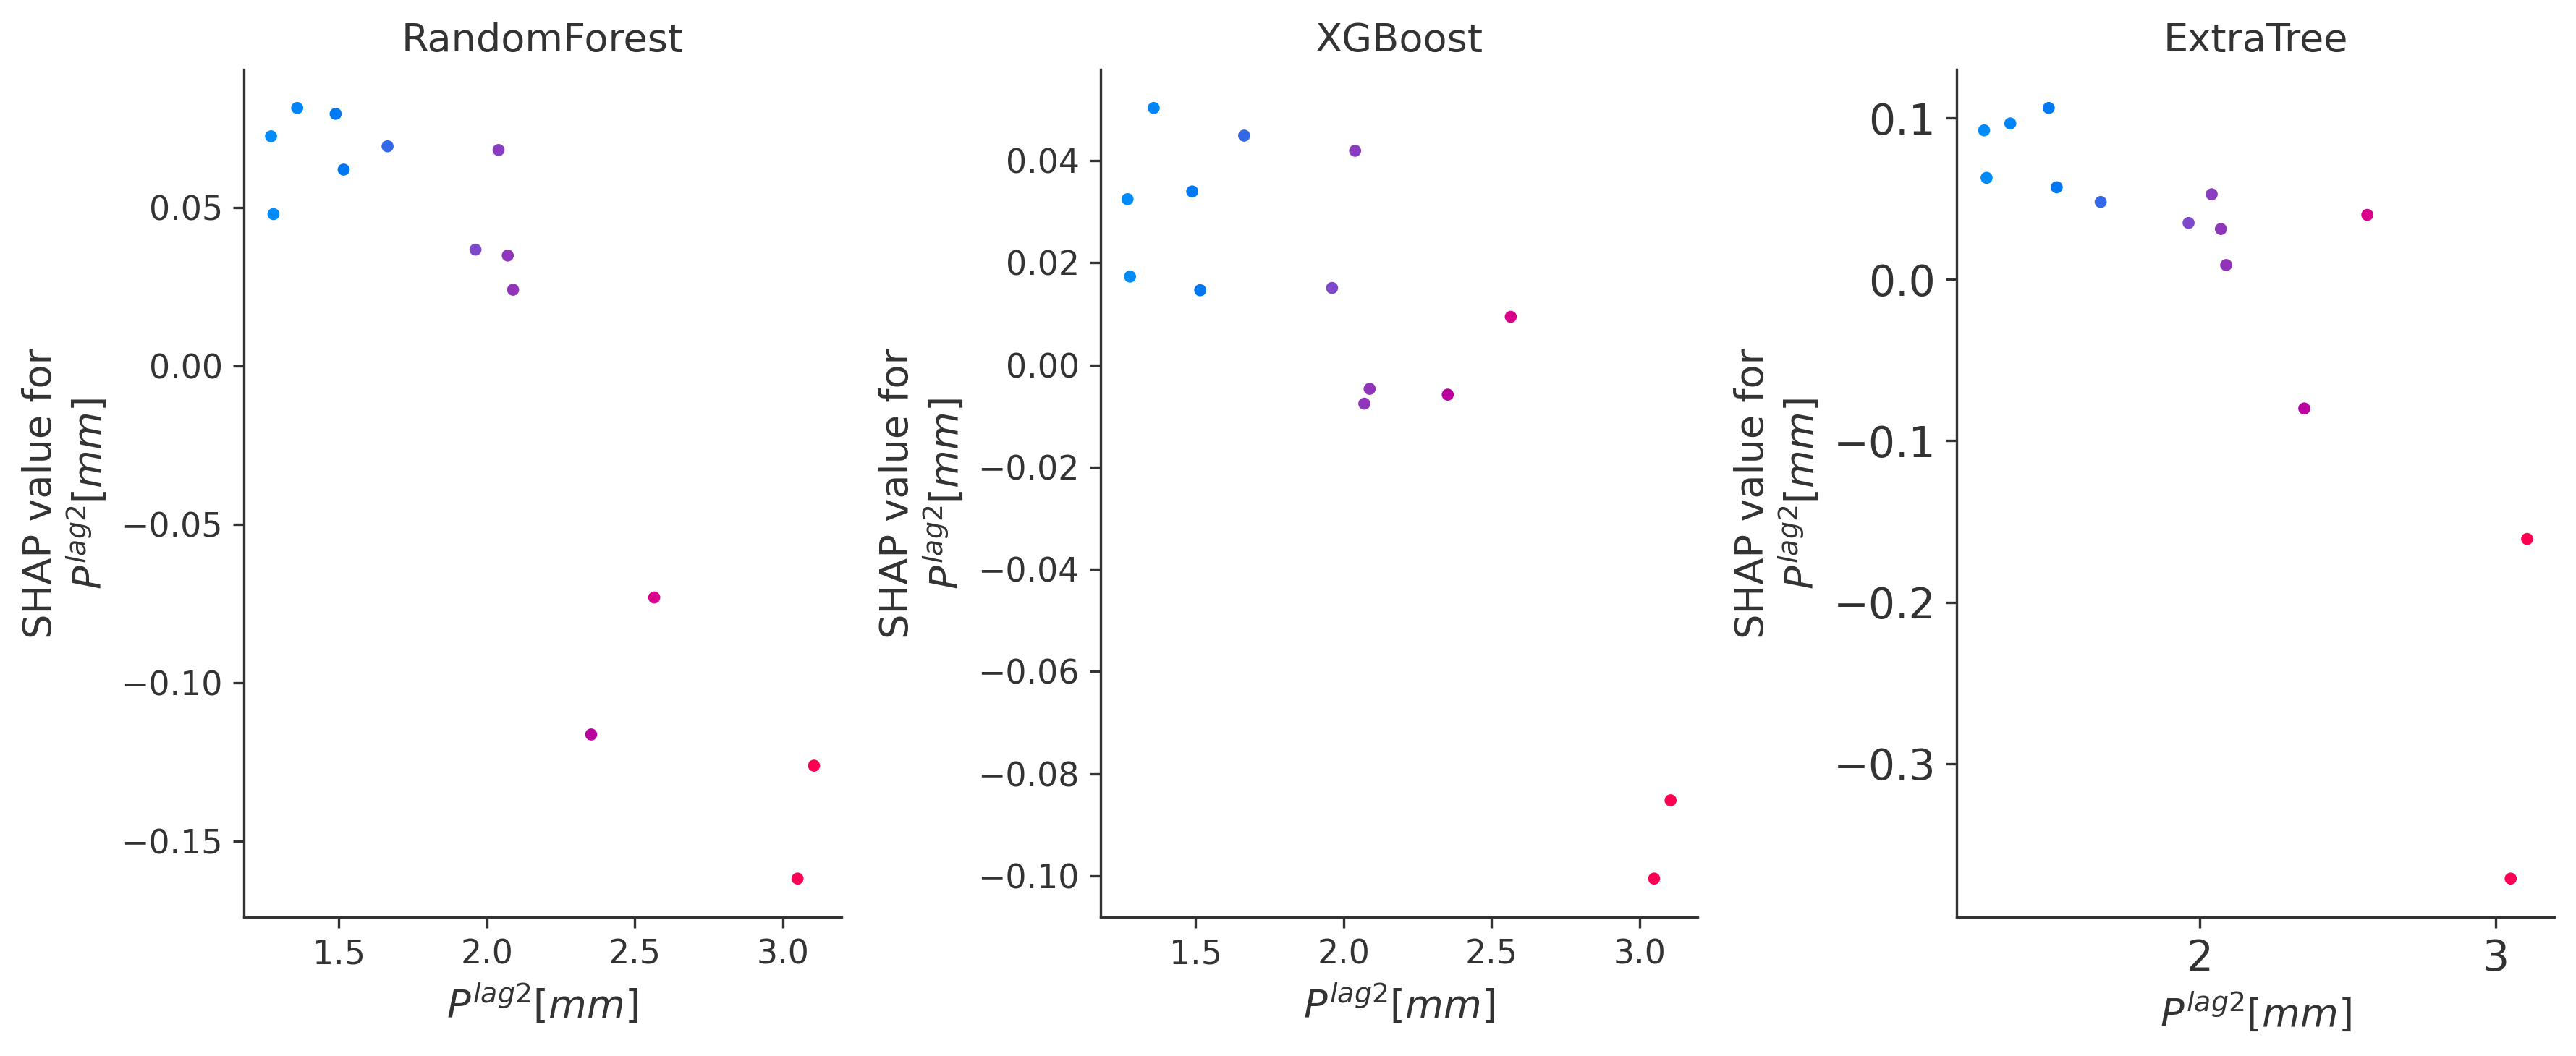

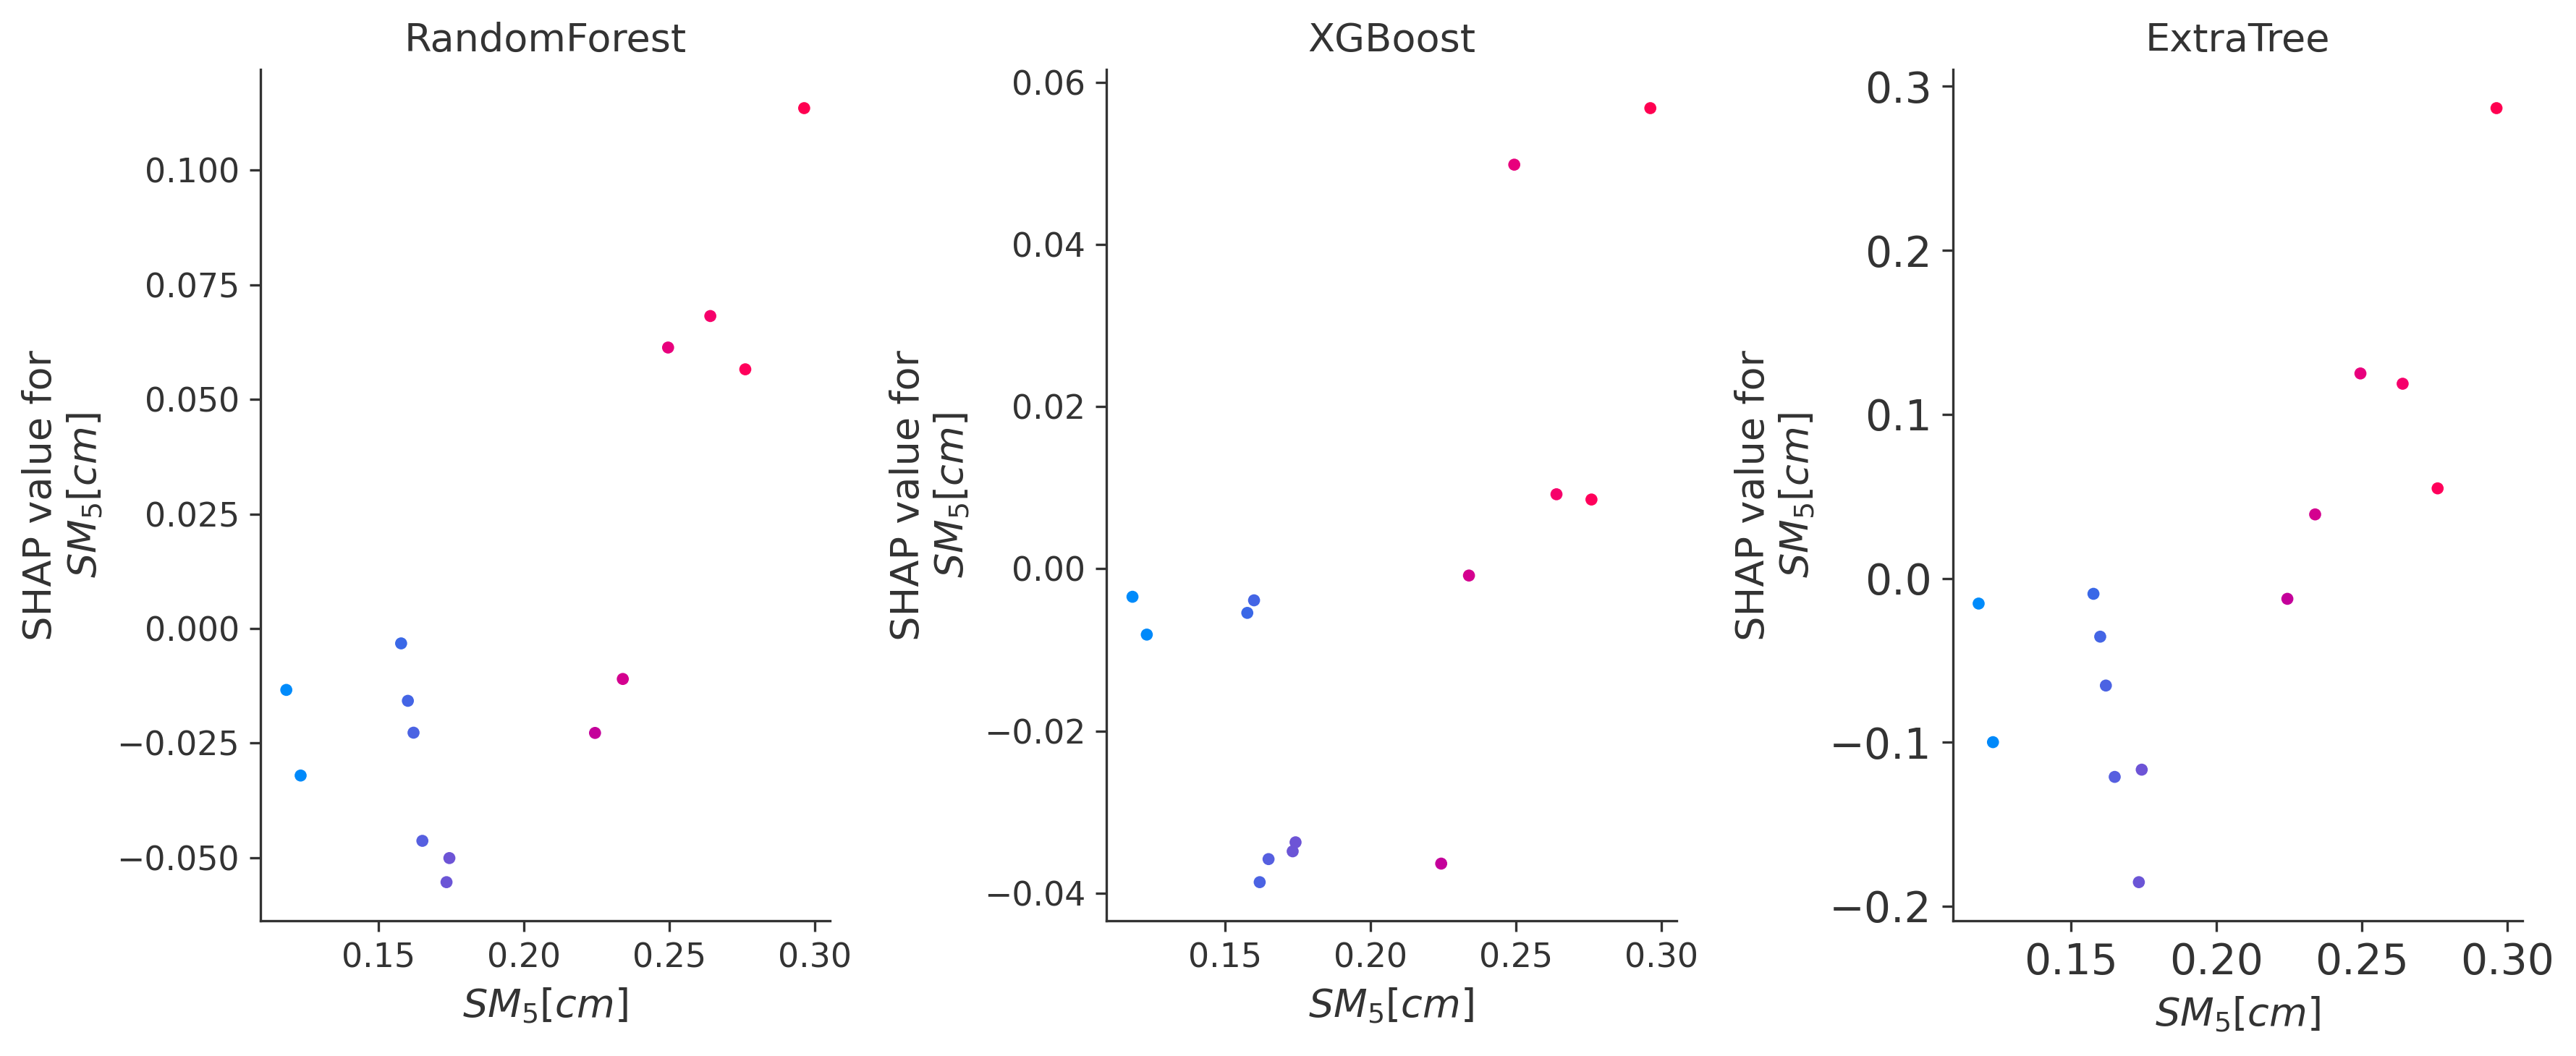

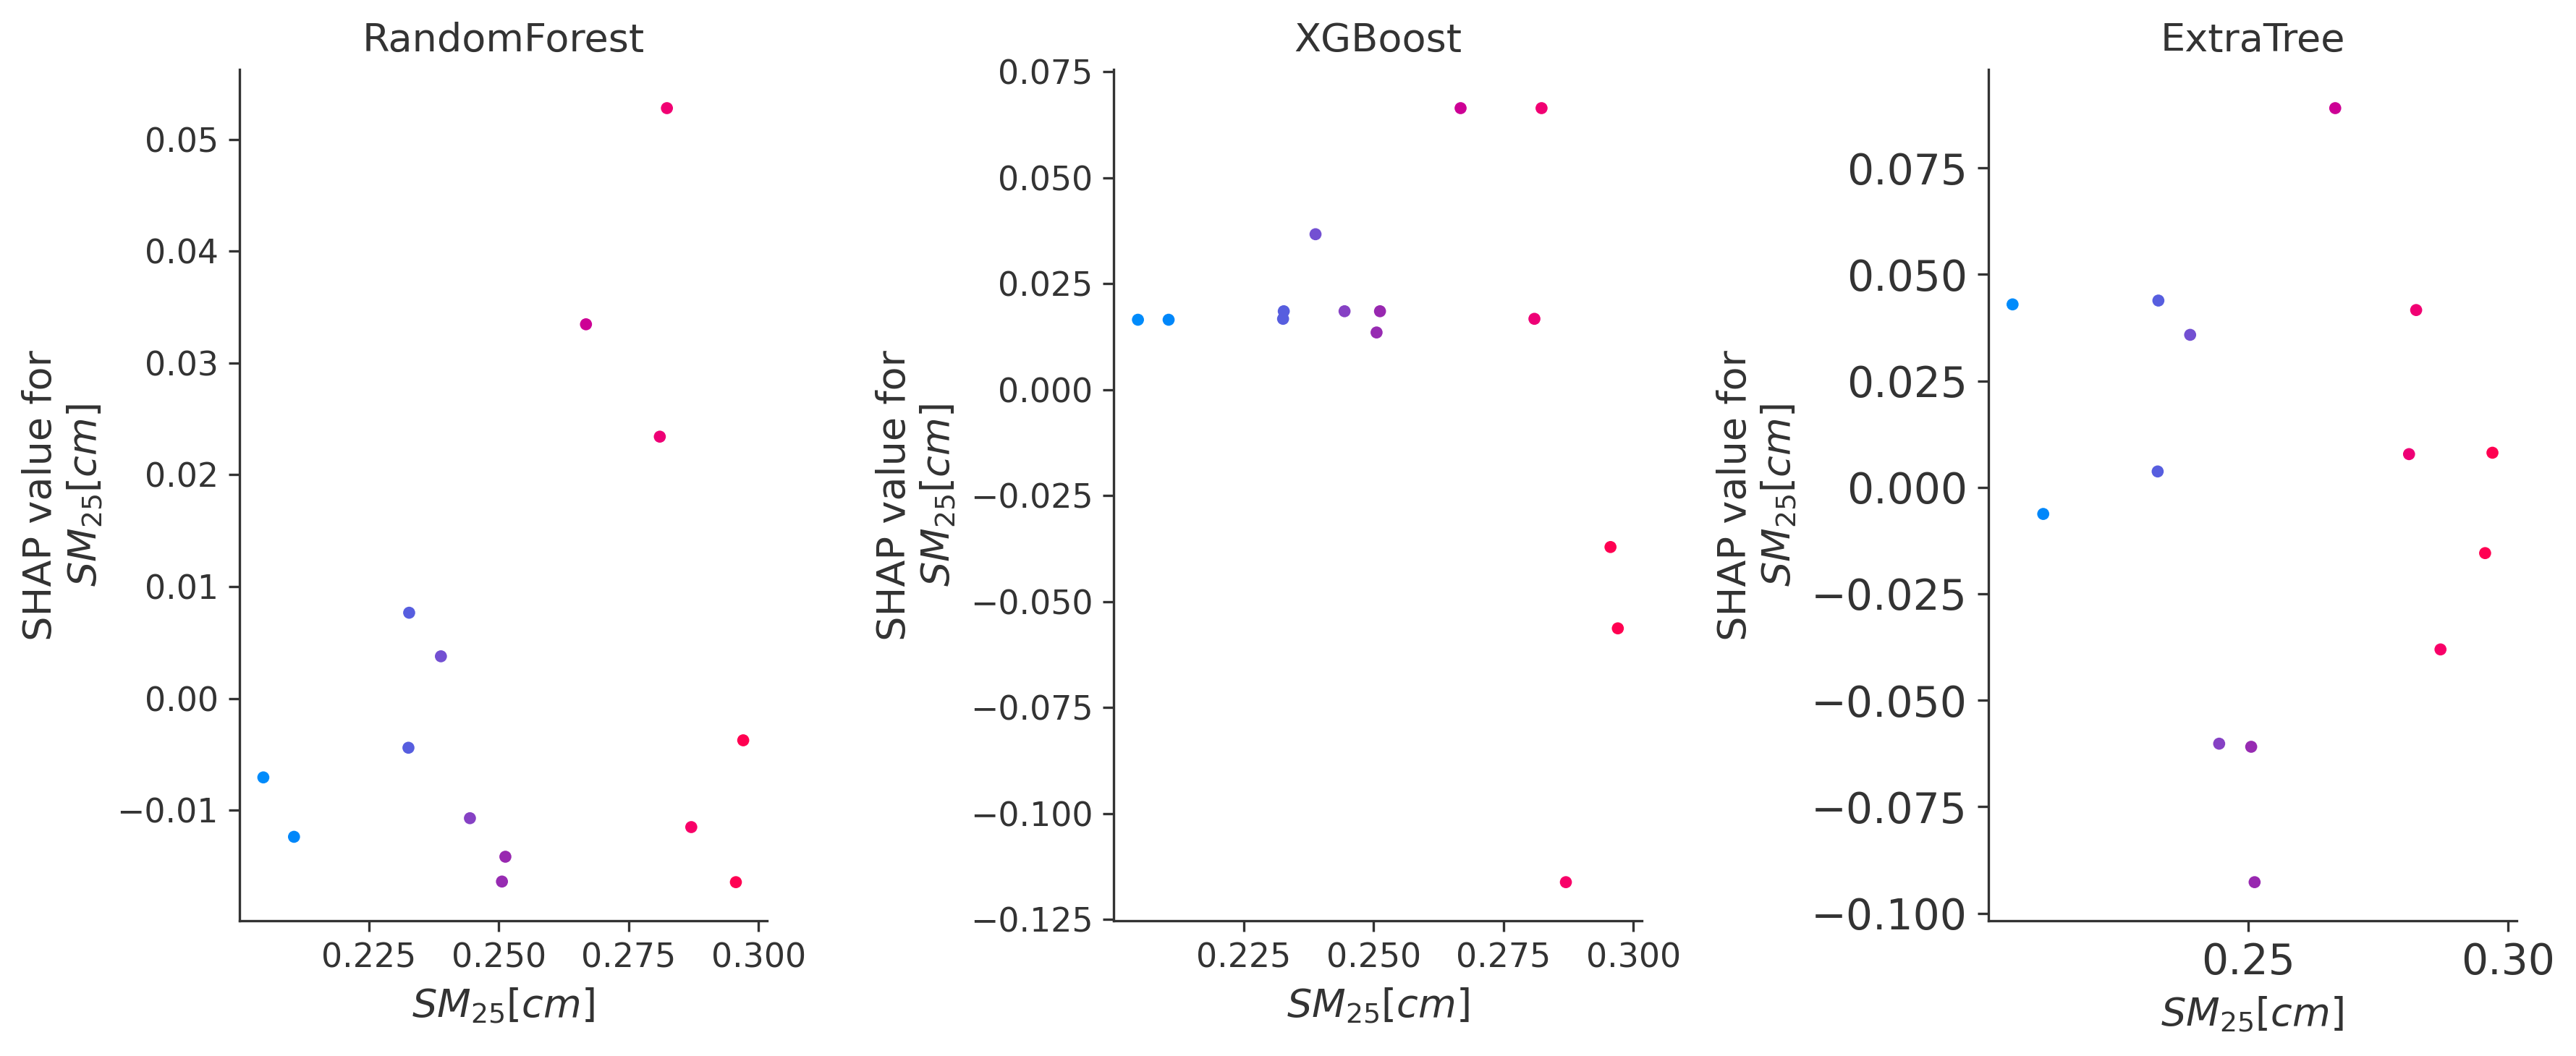

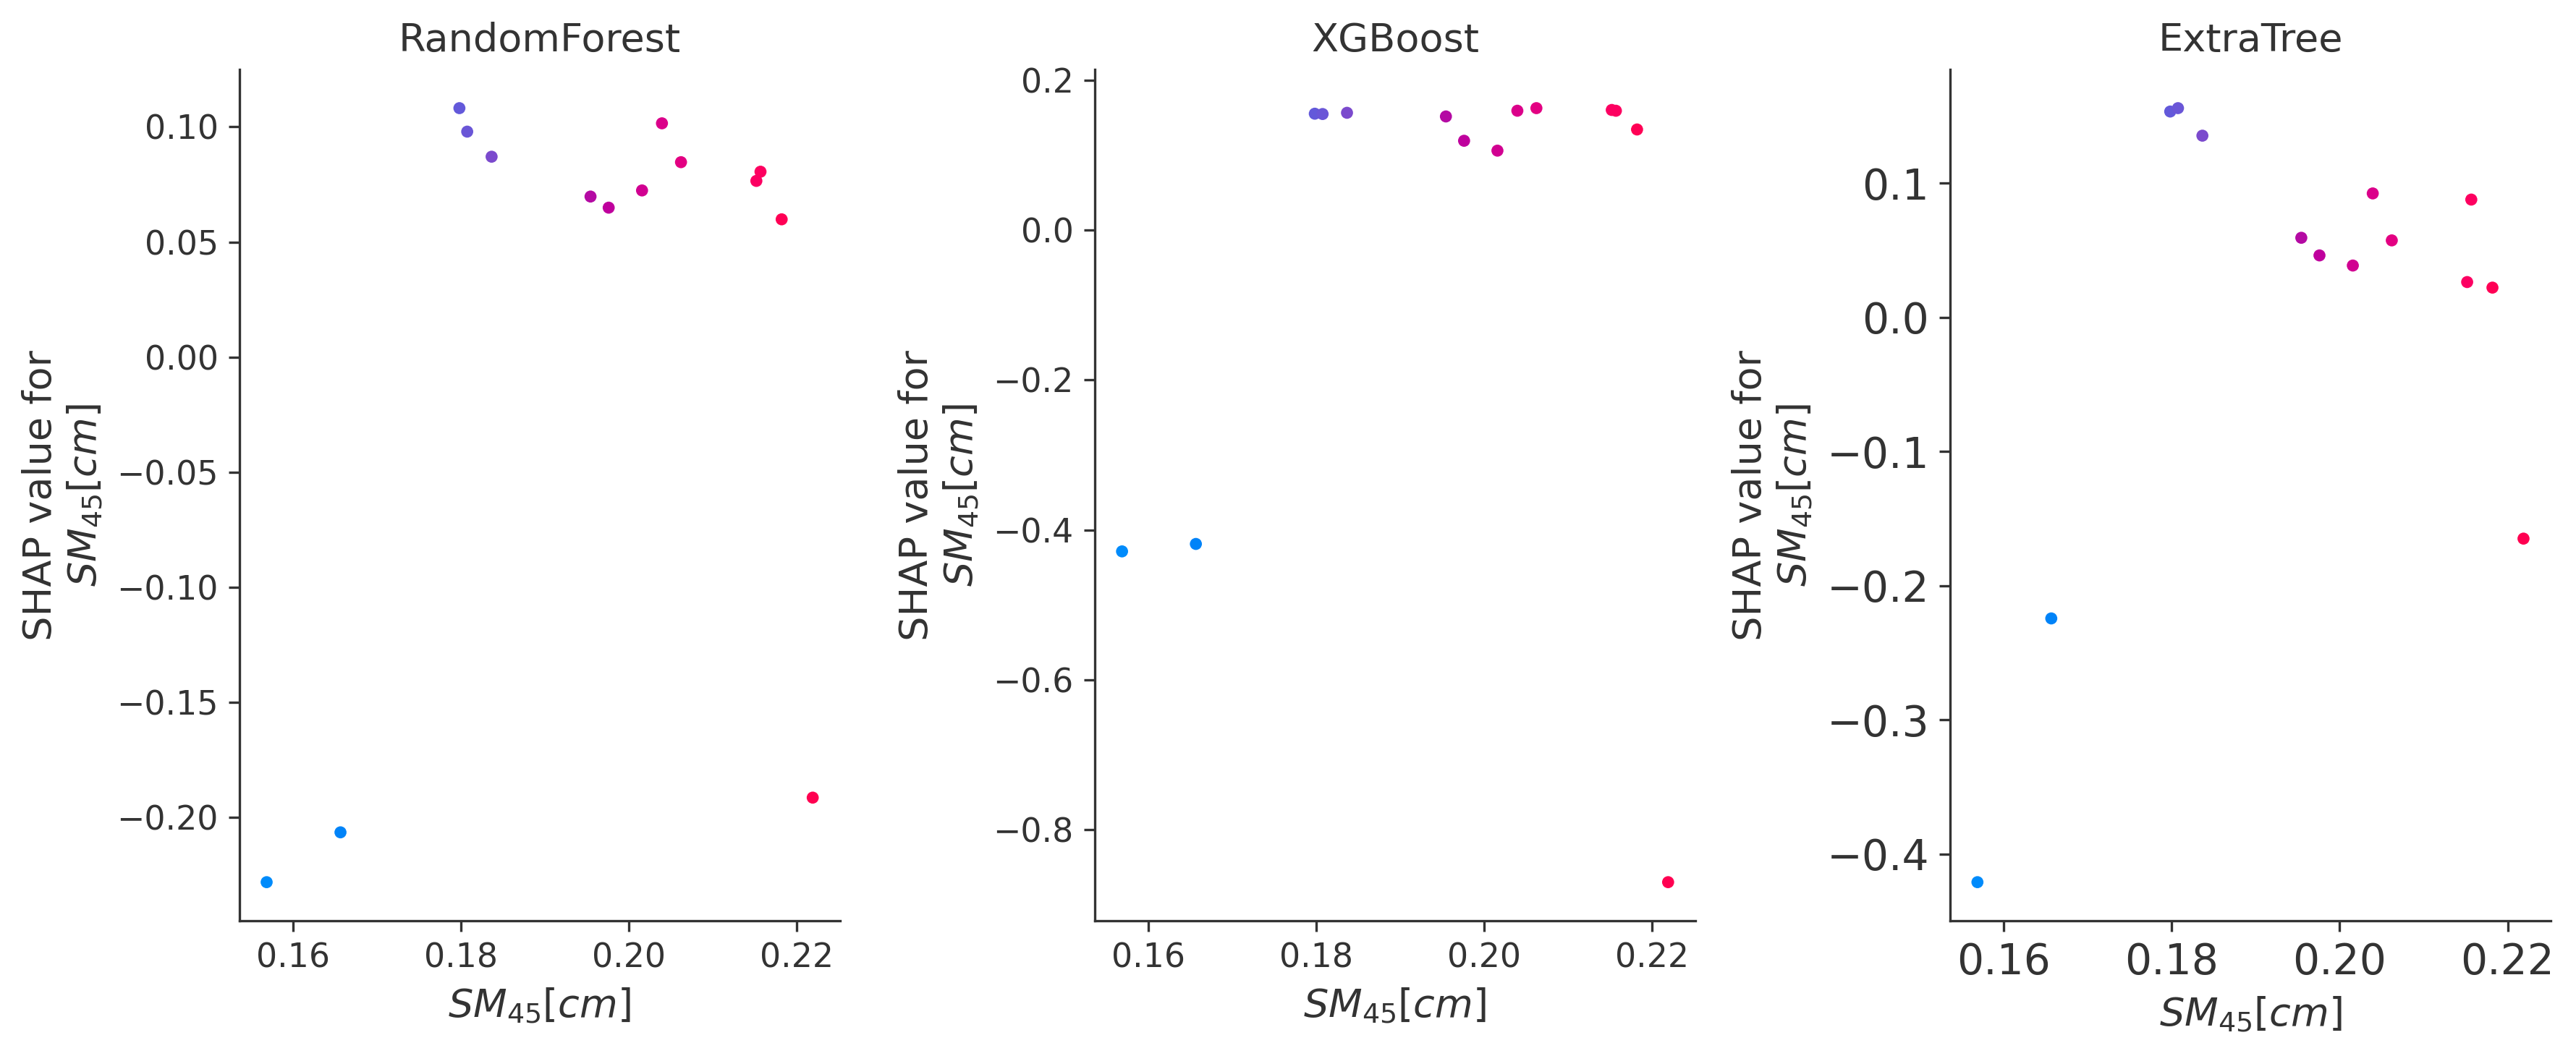

In [98]:
for i in Features:
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=300)
    for count, j in enumerate(keep):
        shap.dependence_plot(i, keep[j], X, Features, ax=ax[count], show=False,
                             interaction_index=i, title=j)
        #ax[count].title(j, fontsize=14)
        plt.tick_params(labelsize=14)
        # plt.ylabel(labelsize=16)
        plt.tight_layout(pad=1.2)
        plt.savefig(path_to_save+r'/Feature Interaction_' + str(i)+'.jpg',
                    format='jpeg', dpi=300, bbox_inches='tight')


The above feature dependency plot is to be improved as we get more data. 